In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

pd.set_option("display.max_columns", None)

DATA_PATH = "/kaggle/input/Cinema_Audience_Forecasting_challenge"

def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

scoring = "neg_root_mean_squared_error"


# **Exploratory Data Analysis**

In [15]:
#  Load all datasets

booknow_visits    = pd.read_csv(f"{DATA_PATH}/booknow_visits/booknow_visits.csv")
booknow_booking   = pd.read_csv(f"{DATA_PATH}/booknow_booking/booknow_booking.csv")
cinePOS_booking   = pd.read_csv(f"{DATA_PATH}/cinePOS_booking/cinePOS_booking.csv")
booknow_theaters  = pd.read_csv(f"{DATA_PATH}/booknow_theaters/booknow_theaters.csv")
cinePOS_theaters  = pd.read_csv(f"{DATA_PATH}/cinePOS_theaters/cinePOS_theaters.csv")
relation_map      = pd.read_csv(f"{DATA_PATH}/movie_theater_id_relation/movie_theater_id_relation.csv")
date_info         = pd.read_csv(f"{DATA_PATH}/date_info/date_info.csv")
sample_sub        = pd.read_csv(f"{DATA_PATH}/sample_submission/sample_submission.csv")

print("Loaded all files!")
print("Loaded shapes:")
print("booknow_visits   :", booknow_visits.shape)
print("booknow_booking  :", booknow_booking.shape)
print("cinePOS_booking  :", cinePOS_booking.shape)
print("booknow_theaters :", booknow_theaters.shape)
print("relation_map     :", relation_map.shape)
print("date_info        :", date_info.shape)


Loaded all files!
Loaded shapes:
booknow_visits   : (214046, 3)
booknow_booking  : (68336, 4)
cinePOS_booking  : (1641966, 4)
booknow_theaters : (829, 5)
relation_map     : (150, 2)
date_info        : (547, 2)


In [17]:
#  Basic EDA on visits

print("\nbooknow_visits head:")
print(booknow_visits.head())


booknow_visits head:
  book_theater_id   show_date  audience_count
0      book_00001  2023-01-13              50
1      book_00001  2023-01-14              64
2      book_00001  2023-01-15              58
3      book_00001  2023-01-16              44
4      book_00001  2023-01-18              12


In [9]:
print("\nDescriptive statistics for audience_count:")
print(booknow_visits["audience_count"].describe())


Descriptive statistics for audience_count:
count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64


In [19]:
booknow_visits["show_date"] = pd.to_datetime(booknow_visits["show_date"])
date_info["show_date"] = pd.to_datetime(date_info["show_date"])

In [21]:
df = booknow_visits.merge(date_info, on="show_date", how="left")

In [24]:
df["day_of_week"] = df["show_date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df["show_date"].dt.month
df["week"] = df["show_date"].dt.isocalendar().week.astype("int64")

df = df.merge(booknow_theaters, on="book_theater_id", how="left")

In [25]:
booknow_booking = booknow_booking.rename(columns={"show_datetime": "show_date"})
cinePOS_booking = cinePOS_booking.rename(columns={"show_datetime": "show_date"})

booknow_booking["show_date"] = pd.to_datetime(booknow_booking["show_date"])
cinePOS_booking["show_date"] = pd.to_datetime(cinePOS_booking["show_date"])

bn_agg = booknow_booking.groupby(["book_theater_id","show_date"])["tickets_booked"].sum().reset_index()
bn_agg = bn_agg.rename(columns={"tickets_booked":"bn_tickets"})

pos_agg = cinePOS_booking.groupby(["cine_theater_id","show_date"])["tickets_sold"].sum().reset_index()
pos_agg = pos_agg.merge(relation_map, on="cine_theater_id", how="left")
pos_agg = pos_agg[["book_theater_id","show_date","tickets_sold"]].rename(columns={"tickets_sold":"pos_tickets"})

df = df.merge(bn_agg, on=["book_theater_id","show_date"], how="left")
df = df.merge(pos_agg, on=["book_theater_id","show_date"], how="left")

df["bn_tickets"] = df["bn_tickets"].fillna(0)
df["pos_tickets"] = df["pos_tickets"].fillna(0)

In [29]:
theater_mean = df.groupby("book_theater_id")["audience_count"].mean().rename("theater_mean")
df = df.merge(theater_mean, on="book_theater_id", how="left")

# **Vizualisation of Some Key Statistics**

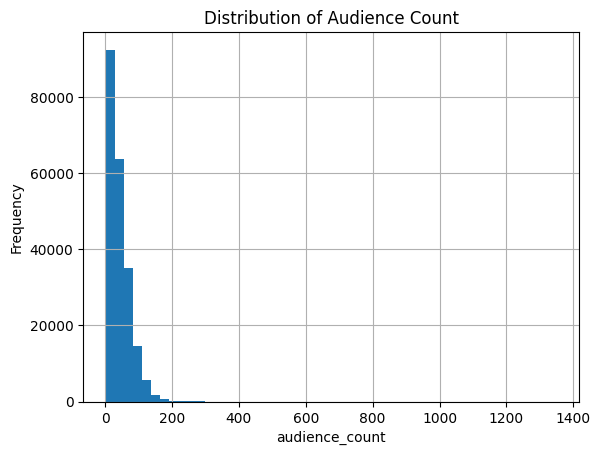

In [26]:
# Audience distribution
plt.figure()
df["audience_count"].hist(bins=50)
plt.title("Distribution of Audience Count")
plt.xlabel("audience_count")
plt.ylabel("Frequency")
plt.show()

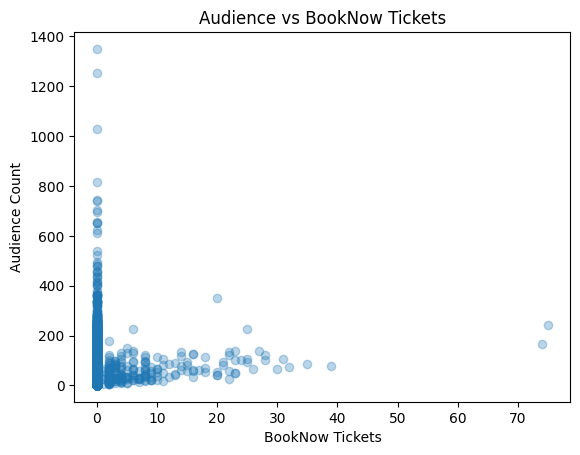

In [27]:
# Tickets vs audience
plt.figure()
plt.scatter(df["bn_tickets"], df["audience_count"], alpha=0.3)
plt.xlabel("BookNow Tickets")
plt.ylabel("Audience Count")
plt.title("Audience vs BookNow Tickets")
plt.show()

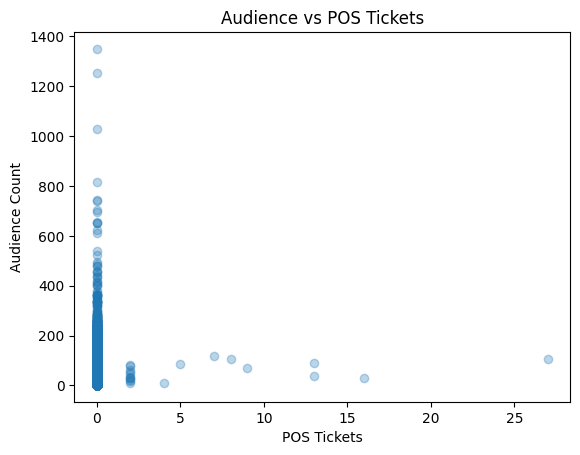

In [28]:
plt.figure()
plt.scatter(df["pos_tickets"], df["audience_count"], alpha=0.3)
plt.xlabel("POS Tickets")
plt.ylabel("Audience Count")
plt.title("Audience vs POS Tickets")
plt.show()

In [30]:
# Group by weekday/weekend
df.groupby("is_weekend")["audience_count"].mean()
df.groupby("day_of_week")["audience_count"].mean()

day_of_week
0    47.623494
1    35.039099
2    35.220707
3    37.992760
4    37.626460
5    45.244812
6    51.713413
Name: audience_count, dtype: float64

# **Feature Engineering**

In [31]:
print("\n Missing values no. in each column:-")
df.isna().sum()


 Missing values no. in each column:-


book_theater_id         0
show_date               0
audience_count          0
day_of_week             0
is_weekend              0
month                   0
week                    0
theater_type       133896
theater_area       133896
latitude           133896
longitude          133896
bn_tickets              0
pos_tickets             0
theater_mean            0
dtype: int64

In [35]:
target = "audience_count"

feature_cols = [
    "day_of_week","is_weekend","month","week",
    "theater_type","theater_area","latitude","longitude",
    "bn_tickets","pos_tickets","theater_mean","book_theater_id"
]

X = df[feature_cols]
y = df[target]

In [37]:
cat_cols = ["theater_type", "theater_area", "book_theater_id"]
num_cols = [c for c in feature_cols if c not in cat_cols]

In [38]:
print("Categorical features:", cat_cols)
print("Numerical features:", num_cols)

Categorical features: ['theater_type', 'theater_area', 'book_theater_id']
Numerical features: ['day_of_week', 'is_weekend', 'month', 'week', 'latitude', 'longitude', 'bn_tickets', 'pos_tickets', 'theater_mean']


# **Preprocessing**

In [39]:

preprocessor = ColumnTransformer([
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),

    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols)
])

# **Train-test Split**

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)


# **Model Training**

In [44]:

models = {
    "Lasso": Lasso(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=50,
        max_depth=4,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.7,
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist"
    )
}

results = []

for name, est in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", est)
    ])
    pipe.fit(X_train, y_train)
    val_pred = pipe.predict(X_val)
    score = rmsle(y_val, val_pred)
    results.append((name, score))
    print(f"{name} RMSLE: {score:.4f}")


Lasso RMSLE: 0.6627
RandomForest RMSLE: 0.6604
XGBoost RMSLE: 0.6290


# **Best Model**

In [45]:
results_sorted = sorted(results, key=lambda x: x[1])
best_model_name, best_score = results_sorted[0]
print("Best model:", best_model_name, "with RMSLE:", best_score)

Best model: XGBoost with RMSLE: 0.6289775046830077


# **Hyperparameter Tuning**

In [46]:
print("\nXGBRegressor")

xgb = XGBRegressor(
    random_state=RANDOM_STATE,
    tree_method="hist",
    objective="reg:squarederror",
    eval_metric="rmsle",
)

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb)
])

xgb_param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
}

xgb_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=15,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

y_val_pred_xgb = xgb_best.predict(X_val)
xgb_rmsle = rmsle(y_val, y_val_pred_xgb)

print("Best XGB params:", xgb_search.best_params_)
print("XGB Validation RMSLE:", xgb_rmsle)


XGBRegressor
Best XGB params: {'model__subsample': 0.9, 'model__n_estimators': 400, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
XGB Validation RMSLE: 0.6151589532858507


# **Model Fitting**

In [48]:
best_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.7,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

final_model = Pipeline([
    ("prep", preprocessor),
    ("xgb", best_xgb)
])

final_model.fit(X, y)   # Train on full dataset


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['theater_type',
                                                   'theater_area',
                                                   'book_theater_id']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['day_of_week', 'i...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.08,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

# **Submission**

In [52]:
test_df = sample_sub.copy()

split = test_df["ID"].str.split("_", n=2, expand=True)
test_df["book_theater_id"] = split[0] + "_" + split[1]
test_df["show_date"] = pd.to_datetime(split[2])

test_df = test_df.merge(date_info, on="show_date", how="left")
test_df = test_df.merge(booknow_theaters, on="book_theater_id", how="left")
test_df = test_df.merge(bn_agg, on=["book_theater_id","show_date"], how="left")
test_df = test_df.merge(pos_agg, on=["book_theater_id","show_date"], how="left")

test_df["bn_tickets"] = test_df["bn_tickets"].fillna(0)
test_df["pos_tickets"] = test_df["pos_tickets"].fillna(0)

test_df["day_of_week"] = test_df["show_date"].dt.dayofweek
test_df["is_weekend"] = test_df["day_of_week"].isin([5, 6]).astype(int)
test_df["month"] = test_df["show_date"].dt.month
test_df["week"] = test_df["show_date"].dt.isocalendar().week.astype("int64")

test_df = test_df.merge(theater_mean, on="book_theater_id", how="left")

X_test = test_df[feature_cols]


In [55]:
final_pred = final_model.predict(X_test)
final_pred = np.maximum(final_pred, 0)

submission = sample_sub.copy()
submission["audience_count"] = final_pred.round().astype(int)
submission.to_csv("submission.csv", index=False)
print("submission.csv saved")
submission.head()

submission.csv saved


,ID,audience_count
0,book_00001_2024-03-01,41
1,book_00001_2024-03-02,55
2,book_00001_2024-03-03,63
3,book_00001_2024-03-04,50
4,book_00001_2024-03-06,38
